<a href="https://cognitiveclass.ai"><img src = "https://imagenes.20minutos.es/files/article_amp/uploads/imagenes/2021/01/28/corruption-2727571-1280-1.png" width = 400> </a>

<h1 align=center><font size = 6>Fake news detection through Machine Learning</font></h1>

## Introduction

Como se menciona en el titulo, vamos a diseñar un modelo de predicción orientado a la detección de noticias falsas. Para esta tarea emplearemos dos formas diferentes de representar palabras y utilizaremos dos modelos logísticos diferentes. A diferencia de proyectos anteriores, vamos a trabajar con dos features que son de tipo texto, añadiendo asi algo de complejidad extra al proyecto.

Nuestro objetivo será comparar resultados entre representaciones diferentes y obtener un clasificador que realice de forma correcta la clasificación.

## Indice

<div class="alert alert-block alert-info" style="margin-top: 20px">

1. [Dataset](#1)<br>
2. [Data Visualization](#2)<br>
3. [Visualizing Data using Matplotlib](#3) <br>
4. [Pie Charts](#4) <br>
5. [Box Plots](#5) <br>
6. [Scatter Plots](#6) <br>
7. [Bubble Plots](#7) <br> 
</div>
<hr>

In [69]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Dataset<a id="1"></a>

Primero de todo, obtendremos el conjunto de datos.

In [7]:
df_fake = pd.read_csv('./Data/Fake.csv')
df_real = pd.read_csv('./Data/True.csv')

Como se observa, los datos estan divididos en dos conjuntos de datos dependiendo de la clase, es por ello que vamos a unirlos para poder trabajar con mas comodidad.

In [30]:
df_fake["label"] = "fake"
df_real["label"] = "real"
df_news = pd.concat([df_fake,df_real]).sample(frac=1)
df_news.reset_index(drop=True, inplace=True)

In [31]:
df_news

,title,text,subject,date,label
0,Syria Strike Completely Backfires Against Tru...,"In case you just woke up, the United States is...",News,"April 7, 2017",fake
1,Senate Republicans rule out action on Obama hi...,WASHINGTON (Reuters) - The Republican-led U.S....,politicsNews,"February 23, 2016",real
2,POPE TAKES COMMUNIST CRUCIFIX GIFT HOME: Says ...,"Well, as a Catholic the act of the Pope of my ...",left-news,"Jul 13, 2015",fake
3,\r\r\r\r\r\r\r\nDonald Trump Gets His A** Hand...,"A 10-year-old girl smacked down Donald Trump, ...",News,"February 29, 2016",fake
4,JOHN KERRY’S STATE DEPT Reportedly Funneled Ov...,So much for the most transparent administrati...,politics,"Sep 13, 2016",fake
...,...,...,...,...,...
44893,U.N. AMB NIKKI HALEY SHOWS PHOTOS…SHOCKS U.N. ...,"BREAKING: In UN, Amb. Haley shows images of ch...",politics,"Apr 5, 2017",fake
44894,Trump’s ‘Major Meeting’ On Veterans Affairs N...,A major meeting on veterans affairs didn t h...,News,"March 19, 2017",fake
44895,WHY THESE ARMY ROTC CADETS WERE PRESSURED INTO...,The wu$$ification of our military Army ROTC ca...,left-news,"Apr 21, 2015",fake
44896,Massachusetts immigrant ruling could guide oth...,BOSTON (Reuters) - A ruling by Massachusetts’ ...,politicsNews,"July 26, 2017",real


## Data Visualization<a id="2"></a>

En este apartado vamos a echar un primer vistazo a los datos, para ver si podemos sacar algún tipo de información de valor antes de ejecutar el preproceso.

In [55]:
df_fake["text"][3]

'On Christmas day, Donald Trump announced that he would  be back to work  the following day, but he is golfing for the fourth day in a row. The former reality show star blasted former President Barack Obama for playing golf and now Trump is on track to outpace the number of golf games his predecessor played.Updated my tracker of Trump s appearances at Trump properties.71 rounds of golf including today s. At this pace, he ll pass Obama s first-term total by July 24 next year. https://t.co/Fg7VacxRtJ pic.twitter.com/5gEMcjQTbH  Philip Bump (@pbump) December 29, 2017 That makes what a Washington Post reporter discovered on Trump s website really weird, but everything about this administration is bizarre AF. The coding contained a reference to Obama and golf:  Unlike Obama, we are working to fix the problem   and not on the golf course.  However, the coding wasn t done correctly.The website of Donald Trump, who has spent several days in a row at the golf course, is coded to serve up the fo

In [54]:
df_real["text"][3]

'WASHINGTON (Reuters) - Trump campaign adviser George Papadopoulos told an Australian diplomat in May 2016 that Russia had political dirt on Democratic presidential candidate Hillary Clinton, the New York Times reported on Saturday. The conversation between Papadopoulos and the diplomat, Alexander Downer, in London was a driving factor behind the FBI’s decision to open a counter-intelligence investigation of Moscow’s contacts with the Trump campaign, the Times reported. Two months after the meeting, Australian officials passed the information that came from Papadopoulos to their American counterparts when leaked Democratic emails began appearing online, according to the newspaper, which cited four current and former U.S. and foreign officials. Besides the information from the Australians, the probe by the Federal Bureau of Investigation was also propelled by intelligence from other friendly governments, including the British and Dutch, the Times said. Papadopoulos, a Chicago-based inte

Despues de visualizar varias instancias de diferente clase, se han observado diferencias:
1. **Longitud:** Las noticias reales tienden a ser más largas.
2. **Menciones:** Las noticias falsas tienden a tener @ de twitter, lo cual hace que no sea una fuente muy fiable.
3. **URL:** Las noticias falsas tienden a tener mas URL que las verdaderas.

### 1. Longitud en base a la clase

In [57]:
def count_word_number(phrase):
    return len(phrase.split())

In [63]:
# Añadir una columna con la longitud de la frase.
df_fake['len'] = df_fake.apply(lambda row : count_word_number(row['text']), axis = 1)
df_real['len'] = df_real.apply(lambda row : count_word_number(row['text']), axis = 1)

In [67]:
import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
langs = ['C', 'C++', 'Java', 'Python', 'PHP']
students = [23,17,35,29,12]
ax.bar(langs,students)
plt.show()

423.1979046888974

<BarContainer object of 2 artists>

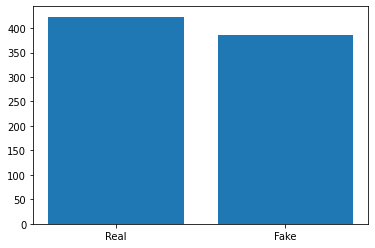

In [70]:
plt.bar(["Real","Fake"], [df_fake['len'].mean(),df_real['len'].mean()])